In [1]:
import cudf
import sys
import scanpy as sc
import scFates as scf
sys.path.append("../ConceptFates/")
sc.settings.verbosity=3
sc.set_figure_params(dpi=150)

import gpu_wrappers
import rapids_scanpy_funcs as rap

In [2]:
import pandas as pd


In [3]:
adata=gpu_wrappers.load_mtx("ML4-5/")


In [5]:
adata.obs["leiden"]=pd.read_table("ML4-5/leiden.tsv",header=None)[0].values.astype(str)

In [6]:
adata.obs["batch"]=list(map(lambda n: n.split("_")[0], adata.obs_names))


In [7]:
adata.obs.batch=adata.obs.batch.astype("category")
adata.obs.leiden=adata.obs.leiden.astype("category")

In [8]:
import proportion_test

In [9]:
prop_res = proportion_test.proportion_test(adata,"batch","leiden","ML4","ML5",
                      n_permutations=10000,n_jobs=10)

100%|██████████| 10000/10000 [00:09<00:00, 1088.48it/s]
/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [10]:
prop_res

,ML4,ML5,obs_log2FD,pval,fdr,boot_mean_log2FD,boot_CI_2.5,boot_CI_97.5,significance
clusters,,,,,,,,,
1,0.255278,0.202604,-0.333410,0.000500,0.001100,-0.335409,-0.538483,-0.134770,n.s.
12,0.011516,0.028478,1.306191,0.001200,0.001886,1.331136,0.504374,2.234358,FDR < 0.05 & abs(Log2FD) > 0.58
13,0.031990,0.021155,-0.596584,0.049195,0.067643,-0.605431,-1.331239,0.057326,n.s.
14,0.003199,0.000814,-1.975095,0.182482,0.182482,NaN,NaN,0.346833,n.s.
2,0.056302,0.093572,0.732891,0.000100,0.000367,0.735520,0.346833,1.129241,FDR < 0.05 & abs(Log2FD) > 0.58
3,0.256558,0.152970,-0.746037,0.000100,0.000367,-0.748957,-0.975095,-0.526375,FDR < 0.05 & abs(Log2FD) > 0.58
4,0.090211,0.145647,0.691097,0.000100,0.000367,0.694983,0.400915,0.999912,FDR < 0.05 & abs(Log2FD) > 0.58
5,0.033909,0.023596,-0.523107,0.066193,0.078862,-0.532409,-1.238130,0.105896,n.s.
6,0.051184,0.086249,0.752825,0.000200,0.000550,0.753369,0.346833,1.172816,FDR < 0.05 & abs(Log2FD) > 0.58


In [13]:
import numpy as np
np.log2(4)

2.0

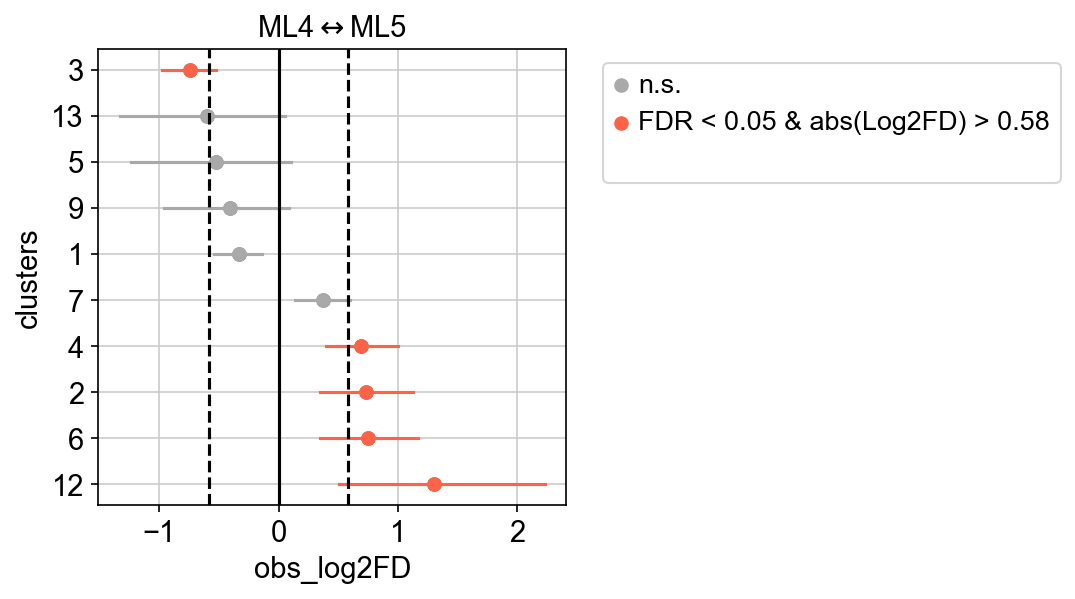

In [11]:
import imp
imp.reload(proportion_test)

import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']
proportion_test.plot_proportion_test(prop_res)

In [17]:
prop_res.to_csv("ML4-5/perm_test_res_ML4-5.csv")

In [14]:
res=pd.DataFrame(0,index=adata.obs.batch.cat.categories,columns=adata.obs.leiden.cat.categories)
res=pd.concat(list(map(lambda b: (adata.obs.loc[adata.obs.batch==b,"leiden"].value_counts()/(adata.obs.batch==b).sum())*100,
         adata.obs.batch.cat.categories)),axis=1)
res.columns=adata.obs.batch.cat.categories

totals=pd.DataFrame(list(map(lambda b: (adata.obs.batch==b).sum(),res.columns)),
            columns=["total"],index=res.columns).T

res.index = res.index.astype(str)

res = pd.concat([res,pd.DataFrame(list(map(lambda b: (adata.obs.batch==b).sum(),res.columns)),
            columns=["total"],index=res.columns).T],axis=0)
res.loc["total"]=res.loc["total"].astype(int)

In [15]:
res.to_csv("ML4-5/prop_totals.csv")